In [4]:
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

df = pd.read_csv('../data/news1.csv', usecols = ['text','date','event'])
df.sort_values(by = ['event'], inplace = True)
df.head()

text        date  \
650  Яндекс.Новости (news.yandex.ru), Москва, 31 ма...  2017-03-31   
672  Top Real Estate (topre.ru), Москва, 31 марта 2...  2017-03-31   
671  Kremlin Press (kremlinpress.com), Москва, 31 м...  2017-03-31   
670  РБК (rbc.ru), Москва, 31 марта 2017 SPACEX ВПЕ...  2017-03-31   
669  Newstes.ru, Москва, 31 марта 2017 SPACEX ВПЕРВ...  2017-03-31   

                                  event  
650  SpaceX запустила и посадила ракету  
672  SpaceX запустила и посадила ракету  
671  SpaceX запустила и посадила ракету  
670  SpaceX запустила и посадила ракету  
669  SpaceX запустила и посадила ракету

In [5]:
df.event.value_counts()

Чемпионат мира по хоккею                            102
Теракт в Барселоне                                  100
Кубок конфедерации FiFA                             100
Путин и Меркель в Сочи                              100
Единый день голосования                             100
Митинг в Москве против коррупции                    100
Ураган в Москве                                     100
Законопроект о курортных сборах                     100
Саммит G20                                          100
Умер Евгений Евтушенко                              100
Акции протеста 12 июня                              100
Передача РПЦ Исаакиевского собора                   100
Теракт в Лондоне                                    100
Умер Виталий Чуркин                                  84
Парламентские выборы в Великобритании                82
Убит Денис Вороненков                                82
Фильм “Он вам не Димон”                              62
Горячая линия Президента Путина                 

In [6]:
%time
import re
from nltk.corpus import stopwords
regex = re.compile("[А-Яа-я]+")

mystopwords = stopwords.words('russian') + ['это', 'наш' , 'тыс', 'млн', 'млрд', 'также',  'т', 'д']
mystoplemmas = ['который','прошлый','сей', 'свой', 'наш', 'мочь', 'такой']

from pymystem3 import Mystem

m = Mystem()

def words_only(text, regex=regex):
    return " ".join(regex.findall(text))

def remove_stopwords(text, mystopwords = mystopwords):
    try:
        return " ".join([token for token in text.split() if not token in mystopwords])
    except:
        return ""

def lemmatize(text, mystem=m):
    try:
        return "".join(m.lemmatize(text)).strip()  
    except:
        return " "
    
def  remove_stoplemmas(text, mystoplemmas = mystoplemmas):
    try:
        return " ".join([token for token in text.split() if not token in mystoplemmas])
    except:
        return ""



df.text = df.text.apply(lemmatize)
df.text = df.text.str.lower()
df.text = df.text.apply(words_only)
df.text = df.text.apply(remove_stopwords)  
df.text = df.text.apply(remove_stoplemmas)  



CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.2 µs


Представление данных в Gensim словарем и корпусом:

In [7]:
from gensim.corpora import *
texts = [df.text.iloc[i].split() for i in range(len(df))]
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

Using TensorFlow backend.


Вычисление сходства по косинусной мере на векторах $tf-idf$:

In [8]:
%%time
from gensim.models import  *
from gensim import similarities

tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

index = similarities.MatrixSimilarity(corpus_tfidf)
sims = index[corpus_tfidf]

CPU times: user 6.64 s, sys: 291 ms, total: 6.93 s
Wall time: 4.25 s


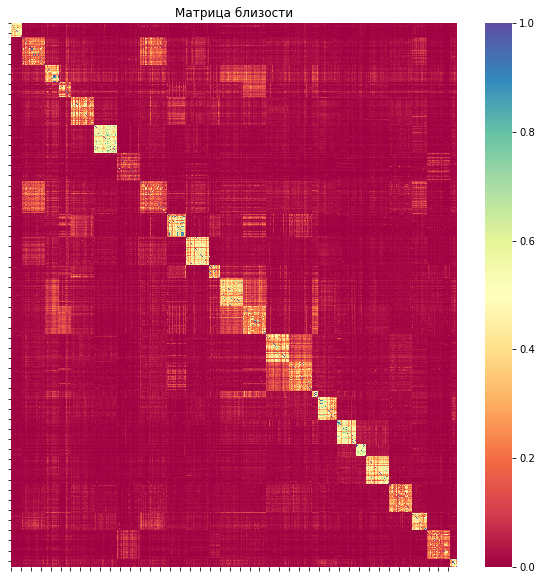

In [9]:
from pylab import pcolor, show, colorbar, xticks, yticks
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize = (10,10))


sns.heatmap(data=sims, cmap = 'Spectral').set(xticklabels=[],yticklabels=[])

plt.title("Матрица близости")
plt.show()

## Модели скрытых тем


![рисунок](img/word2topic2doc.png)

### Латентно-семантический анализ [LSI]

Сингулярное разложение: $M'_k = U \Sigma_k V^t_k$

* $M$ – матрица слово-документ
* $U$ – матрица слово-тема
* $k$ – число тем
* $V$ - матрица документ-тема

In [19]:
%%time
lsi = lsimodel.LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=30)

CPU times: user 1.77 s, sys: 153 ms, total: 1.93 s
Wall time: 1.87 s


In [20]:
lsi.show_topics(5)

[(0,
  '-0.226*"путин" + -0.168*"трамп" + -0.148*"меркель" + -0.133*"президент" + -0.127*"выборы" + -0.116*"курортный" + -0.113*"навальный" + -0.112*"акция" + -0.109*"теракт" + -0.102*"собор"'),
 (1,
  '0.550*"курортный" + 0.466*"сбор" + 0.235*"законопроект" + 0.212*"эксперимент" + 0.158*"инфраструктура" + 0.148*"введение" + 0.130*"вносить" + 0.119*"крым" + 0.119*"край" + 0.111*"алтайский"'),
 (2,
  '0.394*"собор" + 0.295*"исаакиевский" + 0.228*"передача" + -0.227*"путин" + 0.225*"рпц" + 0.212*"акция" + -0.210*"меркель" + -0.161*"трамп" + 0.149*"петербург" + 0.146*"навальный"'),
 (3,
  '0.322*"теракт" + -0.262*"собор" + 0.250*"барселона" + -0.195*"исаакиевский" + -0.175*"путин" + -0.174*"меркель" + 0.171*"лондон" + -0.152*"передача" + -0.148*"рпц" + 0.137*"евтушенко"'),
 (4,
  '0.490*"евтушенко" + 0.326*"чуркин" + 0.317*"поэт" + 0.247*"евгений" + 0.159*"виталий" + 0.158*"умирать" + -0.154*"партия" + 0.134*"оон" + -0.133*"теракт" + -0.116*"великобритания"')]

Как снижение размерности влияет на матрицу близости:

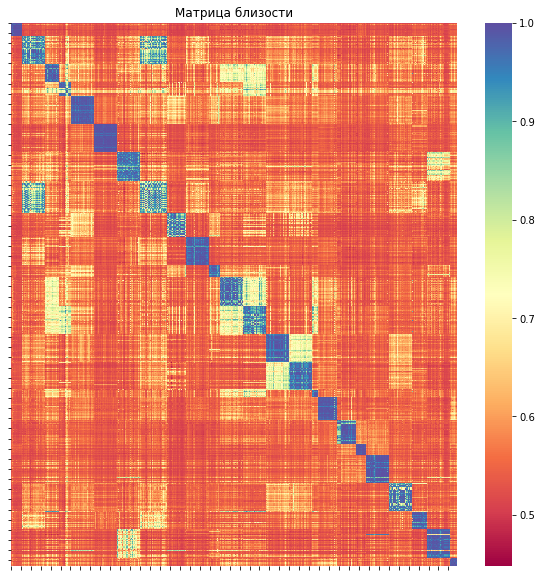

In [21]:
corpus_lsi = lsi[corpus]
index = similarities.MatrixSimilarity(lsi[corpus])
sims = index[corpus_lsi]
sims  = (sims + 1)/2.
plt.figure(figsize = (10,10))
sns.heatmap(data=sims, cmap = 'Spectral').set(xticklabels=[], yticklabels=[])
plt.title("Матрица близости")
plt.show()

### Главные компоненты

In [13]:
X = [0] * len(df)
Y = [0] * len(df)
for i in range(len(df)):
    vec = corpus[i]
    LSI_topics = (lsi[vec])
    try:
        for topic in LSI_topics:
            if topic[0] == 0:
                X[i] = topic[1]
            elif topic[0] == 1:
                Y[i] = topic[1]
    except:
        pass
vis_df = pd.DataFrame({'X': X, 'Y': Y, 'topic' : df.event})

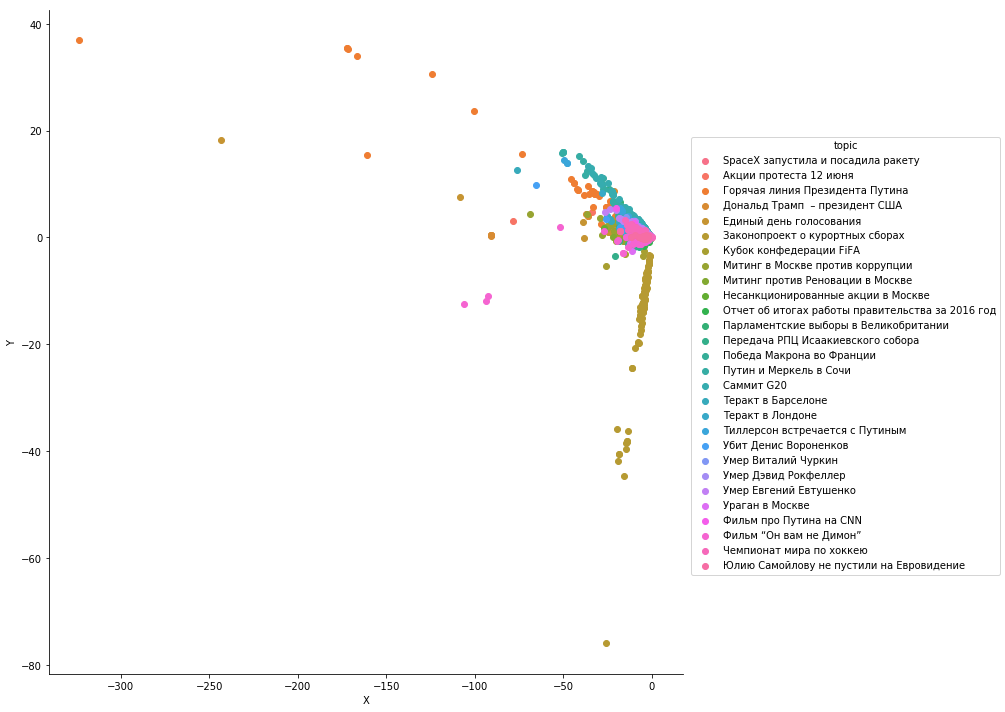

In [14]:
sns.FacetGrid(vis_df, hue="topic", size = 10).map(plt.scatter, "X", "Y").add_legend()

### Латентное размещение Дирихле [LDA]

Генеративная модель порождения документа, оценивает распределение тем по документам и слов по темам:

$p(слово|документ) = \sum_{тема} P(тема|документ) P(слово|тема)$

![](img/tm1.png)

In [16]:
%%time
lda = ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=15,
                        alpha='auto', eta='auto', iterations = 20, passes = 5)

CPU times: user 1min 42s, sys: 671 ms, total: 1min 43s
Wall time: 1min 43s


In [18]:
lda.show_topics(15)

[(0,
  '0.017*"путин" + 0.014*"меркель" + 0.012*"россия" + 0.012*"президент" + 0.009*"выборы" + 0.008*"партия" + 0.008*"встреча" + 0.008*"трамп" + 0.007*"переговоры" + 0.007*"украина"'),
 (1,
  '0.015*"акция" + 0.014*"человек" + 0.014*"митинг" + 0.012*"навальный" + 0.011*"москва" + 0.007*"россия" + 0.007*"власть" + 0.006*"протест" + 0.005*"задерживать" + 0.005*"проходить"'),
 (2,
  '0.020*"евтушенко" + 0.013*"поэт" + 0.012*"год" + 0.012*"евгений" + 0.007*"человек" + 0.005*"россия" + 0.005*"весь" + 0.005*"жизнь" + 0.004*"москва" + 0.004*"становиться"'),
 (3,
  '0.016*"навальный" + 0.012*"москва" + 0.012*"суд" + 0.009*"акция" + 0.008*"митинг" + 0.007*"человек" + 0.007*"россия" + 0.007*"задерживать" + 0.006*"алексей" + 0.006*"полиция"'),
 (4,
  '0.018*"сборная" + 0.016*"матч" + 0.012*"россия" + 0.011*"команда" + 0.009*"чемпионат" + 0.008*"мир" + 0.008*"кубок" + 0.007*"москва" + 0.006*"конфедерация" + 0.005*"игра"'),
 (5,
  '0.020*"теракт" + 0.018*"человек" + 0.013*"барселона" + 0.009*"пол

In [19]:
import pyLDAvis.gensim as gensimvis
import pyLDAvis
vis_data = gensimvis.prepare(lda, corpus, dictionary)
pyLDAvis.display(vis_data)

In [20]:
import plotly.offline as py
import plotly.graph_objs as go

py.init_notebook_mode()

def plot_difference(mdiff, title="", annotation=None):
    """
    Helper function for plot difference between models
    """
    annotation_html = None
    if annotation is not None:
        annotation_html = [
            [
                "+++ {}<br>--- {}".format(", ".join(int_tokens), ", ".join(diff_tokens)) 
                for (int_tokens, diff_tokens) in row
            ] 
            for row in annotation
        ]
        
    data = go.Heatmap(z=mdiff, colorscale='RdBu', text=annotation_html)
    layout = go.Layout(width=500, height=500, title=title, xaxis=dict(title="topic"), yaxis=dict(title="topic"))
    py.iplot(dict(data=[data], layout=layout))

In [21]:
mdiff, annotation = lda.diff(lda, distance='jaccard', num_words=50)
plot_difference(mdiff, title="Topic difference (one model) [jaccard distance]", annotation=annotation)

### TSNE

In [22]:
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer
from sklearn.feature_extraction.text import *

vectors = TfidfVectorizer().fit_transform(df.text)
X_reduced = TruncatedSVD(n_components=5, random_state=0).fit_transform(vectors)
X_embedded = TSNE(n_components=2, perplexity=5, verbose=0).fit_transform(X_reduced)

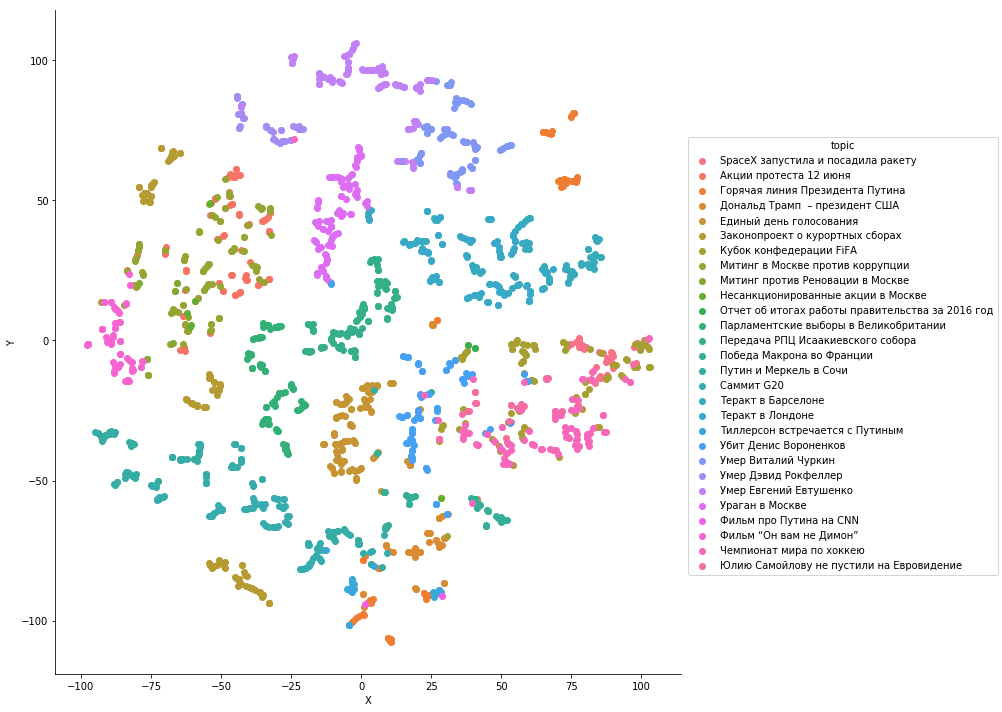

In [23]:
vis_df = pd.DataFrame({'X': X_embedded[:, 0], 'Y': X_embedded[:, 1], 'topic' : df.event})
sns.FacetGrid(vis_df, hue="topic", size=10).map(plt.scatter, "X", "Y").add_legend()